# Tarea_0 ¿Qué es más eficiente para calcular la distribución estacionaria?

Hecho por: Tuli Peña Melo, Juan Bernardo Soto Pescador, Francisco Jose Gutierrez Peña

### Encontrar vector propio ($\pi$) de la matriz de transición ($P$) de la CM con Ql & Usar la función recursiva para encontrar $r_{j}=E_{i}\left[T_{j}^{+}\right]$ componentes de $\pi$

En este código usamos 2.5 maneras distintas (uno podría argumentar que son tres maneras distintas, pero dos son extremadamente similares) de encontrar una distribución estacionaria de la cadena de markov dada en clase.

Es decir, la CM con esta matriz de transición:
$$\begin{bmatrix}
q & p & 0 & 0 & \dots & 0 \\
q & 0 & p & 0 & \dots & 0 \\
0 & q & 0 & p & \dots & 0 \\
0 & 0 & q & 0 & \ddots & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & p \\
0 & 0 & 0 & 0 & q & p
\end{bmatrix}$$

La primera idea surge de este paper https://iate.oac.uncor.edu/~mario/materia/nr/numrec/f11-3.pdf. 
 
Basicamente si tenemos una matriz tridiagonal simetrica, tenemos un algoritmo especial llamado **QL**, donde podemos encontrar los autovalores muy rapidamente, este algoritmo usa rotaciones y corrimientos para encontrar los autovectores con una complejidad de **O(n^2)**.
 
Sin embargo si bien nuestra matriz es tridiagonal *NO ES SIMETRICA*, pero es **reversible** (ya que la cadena de markov es reversible (esto se puede evidenciar pues es irreducible, o más abajo tenemos otra demostración)), entonces existe una matriz simetrica tridiagonal S, tal que S=DPD^-1.

Para esto usamos la librería de scipy que ya tiene un modulo integrado sobre este tipo de matrices.

Hay dos versiones del algoritmo con matrices, una carga toda la matriz n x n, mientras que la otra usa la estructura de la matriz calcular la matriz S. Los dos algoritmos tienen una velocidad casi identica, pero el **segundo algoritmo** procesa cadenas de markov de hasta *10^5 estados*, mientras que el primero empieza a tener errores de memoria con este tipo de valores.

El otro algoritmo fundamentalmente distinto es el **algoritmo de tiempos medios de regreso**. En está implementación hay n-1 ecuaciones lineales que resolver lo cual tiene una complejidad de **O(n^3)**, y hacemos esto por cada estado es decir la complejidad queda de **O(n^4)**.

Por la teoría la diferencia es clara y en lo practico tambien, ya que el algoritmo tiene problemas con valores de n semejantes a 10^4

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal

# --- Algoritmo 1: versión densa ---
def build_P(n, p):
    P = np.zeros((n, n), dtype=float)
    for i in range(n-1):
        P[i, i+1] = p
    for i in range(1, n):
        P[i, i-1] = 1.0 - p
    P[0,0] = 1.0 - p
    P[-1,-1] = p
    return P

def stationary_via_tqli_dense(P, p=None):
    n = P.shape[0]
    if p is None:
        p = float(P[0,1])
    q = 1.0 - p
    r = p / q
    indices = np.arange(n, dtype=float)
    pi_unnorm = r ** indices
    D = np.sqrt(pi_unnorm)

    d = np.array([P[i,i] for i in range(n)], dtype=float)
    e = np.array([np.sqrt(P[i,i+1]*P[i+1,i]) for i in range(n-1)], dtype=float)

    evals, evecs = eigh_tridiagonal(d, e)
    idx = np.argmin(np.abs(evals - 1.0))
    v = evecs[:, idx]

    pi_col = D * v
    if pi_col.sum() < 0:
        pi_col = -pi_col
    pi = np.where(pi_col < 0, 0.0, pi_col)
    return pi / pi.sum()

# --- Algoritmo 2: tridiagonal optimizado ---
def stationary_via_tqli_tridiag(n, p):
    q = 1.0 - p
    r = p / q
    indices = np.arange(n, dtype=float)
    pi_unnorm = r ** indices
    D = np.sqrt(pi_unnorm)

    d = np.zeros(n)
    d[0] = 1.0 - p
    d[-1] = p
    e = np.sqrt(p*q) * np.ones(n-1)

    evals, evecs = eigh_tridiagonal(d, e)
    idx = np.argmin(np.abs(evals - 1.0))
    v = evecs[:, idx]
    pi_col = D * v
    if pi_col.sum() < 0:
        pi_col = -pi_col
    pi = np.where(pi_col < 0, 0.0, pi_col)
    return pi / pi.sum()

# --- Algoritmo 3: tiempos medios de regreso ---
def stationary_via_return_times(P, tol=1e-12, use_lstsq_on_singular=True):
    P = np.array(P, dtype=float)
    n = P.shape[0]
    r = np.empty(n, dtype=float)
    for i in range(n):
        idx = [j for j in range(n) if j != i]
        if len(idx) == 0:
            r[i] = 1.0
            continue
        A = np.eye(n-1) - P[np.ix_(idx, idx)]
        b = np.ones(n-1)
        try:
            t_sub = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            if not use_lstsq_on_singular:
                raise
            t_sub, *_ = np.linalg.lstsq(A, b, rcond=None)
        r[i] = 1.0 + np.dot(P[i, idx], t_sub)
    inv_r = 1.0 / r
    pi = inv_r / np.sum(inv_r)
    return pi, r

# --- Benchmark con gráfico ---
def benchmark_three_methods(max_n_matrix=800, max_n_recursive=5000, steps=6, p=0.3):
    """
    Compara los tres métodos (denso, tridiag, return_times) en función de n.
    - max_n_dense: límite superior para el método denso (memoria restringida).
    - max_n_tridiag: límite superior para tridiag y return_times.
    - steps: número de puntos de prueba.
    """
    ns_matrix = np.linspace(100, max_n_matrix, steps, dtype=int)
    ns_recursive = np.linspace(100, max_n_recursive, steps, dtype=int)

    tiempos_dense, tiempos_tridiag, tiempos_return = [], [], []

    # --- Denso ---
    for n in ns_matrix:
        P = build_P(n, p)
        start = time.time()
        stationary_via_tqli_dense(P, p)
        end = time.time()
        tiempos_dense.append(end - start)
        print(f"[Denso] n={n:5d} -> {end-start:.4f} seg")

    # --- Tridiag ---
    for n in ns_matrix:
        start = time.time()
        stationary_via_tqli_tridiag(n, p)
        end = time.time()
        tiempos_tridiag.append(end - start)
        print(f"[Tridiag] n={n:5d} -> {end-start:.4f} seg")

    # --- Return times ---
    for n in ns_recursive:  # mismo rango que tridiag
        P = build_P(n, p)
        start = time.time()
        stationary_via_return_times(P)
        end = time.time()
        tiempos_return.append(end - start)
        print(f"[ReturnTimes] n={n:5d} -> {end-start:.4f} seg")

    # --- Gráfico comparativo ---
    plt.figure(figsize=(9,6))
    plt.plot(ns_matrix, tiempos_dense, "o-", label="Denso (eigh_tridiagonal con P entera)")
    plt.plot(ns_matrix, tiempos_tridiag, "s-", label="Tridiag optimizado")
    plt.plot(ns_recursive, tiempos_return, "^-", label="Return Times")
    plt.title("Comparación de tiempos de ejecución de los tres métodos")
    plt.xlabel("Tamaño de la matriz n")
    plt.ylabel("Tiempo (segundos)")
    
    plt.xscale("log")   # eje X logarítmico
    plt.yscale("log")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Ejemplo de uso
if __name__ == "__main__":
    
    benchmark_three_methods(max_n_matrix=30000, max_n_recursive=1000, steps=6, p=0.3)

### Usar la reversibilidad de la CM para encontrar $\pi$

### Proof

An Birth-Death Process is a special case of continuous-time Markov process where the state transitions are of only 2 types "births" (increasing the state var by 1), and "deaths" (decreasing state by one).

Our Markov Chain nxn transition matrix $P$ looks like this:
$$\begin{bmatrix}
q & p & 0 & 0 & \dots & 0 \\
q & 0 & p & 0 & \dots & 0 \\
0 & q & 0 & p & \dots & 0 \\
0 & 0 & q & 0 & \ddots & 0 \\
\vdots & \vdots & \vdots & \ddots & \ddots & p \\
0 & 0 & 0 & 0 & q & p
\end{bmatrix}$$
In this case we would have a discrete-time, finite-state BDP; or also a Nearest-Neighbor Random Walk (we will also see what happens when the walk is biased ($p\neq q$).

First we would like to prove that the stationary distribution $\pi$ must satisfy the Detailed Balance property ($\pi_{j}P_{ij}= \pi_{j}P_{ji}$).

Suppose $\pi$ stationary distribution of $P$ transition matrix, because $\pi$ is stationary we have that is invariant over P so:
$$\sum_{j=1}^{N}\pi_{j}P_{ji}=\pi_{i}$$

Since our $P$ matrix is tridiagonal and $P_{ii}=0$ for all $i\neq 1,n$ we would have for internal states:
$$\pi_{i}=\pi_{i-1}P_{i-1,i}+\pi_{i+1,i}P_{i+1,i}$$

Using that $P_{i-1,i}=p$ and $P_{i+1,i}=q$:
$$\pi_{i}=\pi_{i-1}p+\pi_{i+1,i}q$$

We have that the row sum for all internal states is 1 so $P_{i,i-1}+P_{i,i+1}=1$:
$$\pi_{i}(P_{i,i-1}+P_{i,i+1})=\pi_{i-1}p+\pi_{i+1,i}q$$

We rearrange the terms to see the probability flow between adjacent boundaries:
$$\pi_{i}P_{i,i-1}-\pi_{i-1}P_{i-1,i}=\pi_{i+1,i}P_{i+1,i}-\pi_{i}P_{i,i+1}$$
So in the left side of the equation we have the flow left out of i into i-1, and in the right side the flow left out of i+1 into i.

So we have that the net probability flux between any pair of states (i-1,i) is constant across all the internal stats:
$$\pi_{i}q-\pi_{i-1}p=C (\text{for } 2 \leq i \leq N-1)$$

For ($i=1$) we have:
$$\pi_1 = \pi_1 P_{1, 1} + \pi_2 P_{2, 1}$$

Substituting $P_{1,1}=q$ and $P_{2,1}=q$:
$$\pi_1 = \pi_1 q + \pi_2 q$$
$$\pi_2 q = \pi_1 (1 - q)$$

Since $p+q=1$, $1-q=p$:
$$\pi_2 q = \pi_1 p$$

So we have Detailed balance between state 1 and 2.

For ($i=N$) we will have:
$$\pi_N = \pi_{N-1} P_{N-1, N} + \pi_N P_{N, N}$$

Substituting $P_{N-1, N}=p$ and $P_{N, N}=p$:
$$\pi_N = \pi_{N-1} p + \pi_N p$$
$$\pi_{N-1} p = \pi_N (1 - p)$$

Since $1-p=q$:
$$\pi_{N-1} p = \pi_N q$$

So we have Detailed balance between state N-1 and N.

Because the flux C is constant through the chain it must be 0 everywhere so:
$$\pi_{i}q-\pi_{i-1}p=C \Longrightarrow \pi_{i}q=\pi_{i-1}p$$

So our chain has Detailed balance and is reversible.

(Actually we would also have this because the BDP was irreducible xdn't)

### Calculate stationary distribution

Given that our chain has Detail Balance and is reversible we simply have:

$$\pi_{i}=\left(\frac{p}{q}\right)\pi_{i-1}$$

We can see the structure of the components of $\pi$ recursively with the bias ratio $r=\frac{p}{q}$:
| State $i$ | Relation to $\pi_{i-1}$ | Relation to $\pi_1$ |
| :---: | :---: | :--- |
| 2 | $\pi_2 = r \cdot \pi_1$ | $\pi_2 = r^1 \pi_1$ |
| 3 | $\pi_3 = r \cdot \pi_2$ | $\pi_3 = r^2 \pi_1$ |
| $i$ | $\pi_i = r \cdot \pi_{i-1}$ | $\pi_i = r^{i-1} \pi_1$ |
| $N$ | $\pi_N = r \cdot \pi_{N-1}$ | $\pi_N = r^{N-1} \pi_1$ |

We have this geometric sequence $(1, r, r^2, \dots, r^{N-1})$.

Because $\pi$ is a probability distribution the sum of all the components must be 1:

$$\sum_{i=1}^N \pi_{i} = \pi_{1} + \pi_{2} + \dots + \pi_{N} = 1$$

We can substitute with the sequence we found earlier:

$$\pi_{1} (1 + r + r^2 + \dots + r^{N-1}) = 1$$

The sequence we found is a finite geometric series that is:
$$1+r+r^2 + \cdots + r^{N-1} = \frac{r^{N} - 1}{r-1}$$

So finally we have that:
$$\pi_{1} = \frac{r-1}{r^{N} - 1}$$

#### We have 2 important cases:

#### Unbiased Walk (so p=q and r=1):

We have that r=1 so the series sum is $1+1+\dots+1=N$
$$\pi_{1}=\frac{1}{N}$$

Since $\pi_{i} = 1^{i-1} \pi_{1}$, all components are equal.$$\pi_{i} = \frac{1}{N}$$

#### Biased Walk ($p \neq q$, so $r \neq 1$)
We have the general term $\pi_{i} = r^{i-1} \pi_1$ so:
$$\pi_i = r^{i-1} \cdot \left(\frac{r-1}{r^{N}-1}\right)$$

p=0.100, n=10, median_time=0.000044s
p=0.100, n=100, median_time=0.000046s
p=0.100, n=1,000, median_time=0.000079s
p=0.100, n=10,000, median_time=0.000351s
p=0.100, n=100,000, median_time=0.004171s
p=0.100, n=1,000,000, median_time=0.036884s
p=0.500, n=10, median_time=0.000028s
p=0.500, n=100, median_time=0.000024s
p=0.500, n=1,000, median_time=0.000024s
p=0.500, n=10,000, median_time=0.000031s
p=0.500, n=100,000, median_time=0.000111s
p=0.500, n=1,000,000, median_time=0.003521s
p=0.900, n=10, median_time=0.000037s
p=0.900, n=100, median_time=0.000035s
p=0.900, n=1,000, median_time=0.000185s
p=0.900, n=10,000, median_time=0.000172s
p=0.900, n=100,000, median_time=0.001299s


/tmp/ipykernel_45227/4088130351.py:53: RuntimeWarning: overflow encountered in power
  numer = np.power(r, exponents) * (r - 1.0)
/tmp/ipykernel_45227/4088130351.py:53: RuntimeWarning: overflow encountered in multiply
  numer = np.power(r, exponents) * (r - 1.0)
/tmp/ipykernel_45227/4088130351.py:54: RuntimeWarning: overflow encountered in power
  denom = np.power(r, n) - 1.0
/tmp/ipykernel_45227/4088130351.py:55: RuntimeWarning: invalid value encountered in divide
  pi = numer / denom


p=0.900, n=1,000,000, median_time=0.018944s


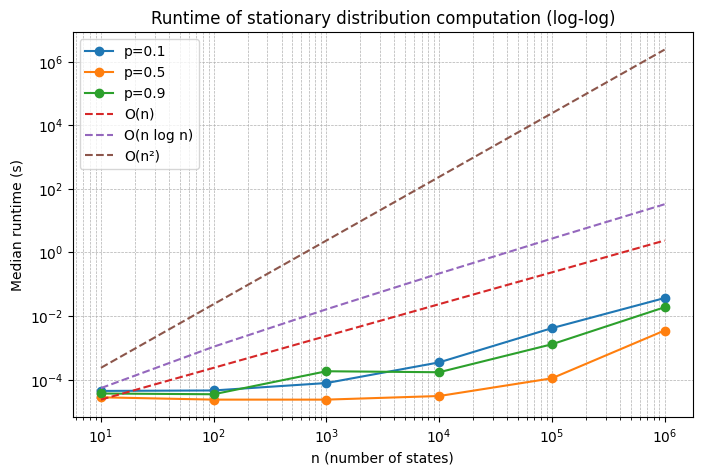

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from math import log, exp, isclose
import pandas as pd
import os

def stationary_reversible_tridiagonal(p: float, n: int) -> np.ndarray:
    """
    Return the stationary distribution pi for the n-state chain.
    p = probability p <= 1
    n = size of the transition matrix
    
    The formula used:
        pi_i = r^{i-1} * (r-1) / (r^n - 1),  i=1..n  with r = p/q
    Edge cases handled:
      - p == 1  -> absorbing at state n (pi = e_n)
      - p == 0  -> absorbing at state 1 (pi = e_1)
      - r == 1  -> limit r->1 gives uniform distribution (p == q == 1/2)
      - n == 1  -> single-state chain pi = [1]
    """
    
    if not (0.0 <= p <= 1.0):
        raise ValueError("p must be in [0,1]")
    if not (isinstance(n, int) and n >= 1):
        raise ValueError("n must be a positive integer")
    
    q = 1.0 - p
    # trivial 1-state chain
    if n == 1:
        return np.array([1.0], dtype=float)
    # edge absorbing cases
    if np.isclose(p, 1.0):
        pi = np.zeros(n, dtype=float)
        pi[-1] = 1.0
        return pi
    if np.isclose(p, 0.0):
        pi = np.zeros(n, dtype=float)
        pi[0] = 1.0
        return pi
    
    # general case
    # r = p/q (note q is not zero here because p not 1)
    r = p / q
    if np.isclose(r, 1.0):
        # limit as r -> 1 gives uniform distribution
        return np.ones(n, dtype=float) / n
    
    # compute vector safely
    # use powers r**(i) for i=0..n-1 which correspond to r^{i-1} when i=1..n
    exponents = np.arange(n, dtype=float)  # 0..n-1
    # compute numerator and denominator; then normalize to guard against tiny rounding errors
    numer = np.power(r, exponents) * (r - 1.0)
    denom = np.power(r, n) - 1.0
    pi = numer / denom
    # numerical safety: renormalize
    pi = pi / np.sum(pi)
    return pi

def build_transition_matrix(p: float, n: int) -> np.ndarray:
    """Construct the n x n transition matrix P."""
    q = 1.0 - p
    P = np.zeros((n, n), dtype=float)
    if n == 1:
        P[0,0] = 1.0
        return P
    # first row
    P[0,0] = q
    P[0,1] = p
    # interior rows
    for i in range(1, n-1):
        P[i, i-1] = q
        P[i, i+1] = p
    # last row
    P[n-1, n-2] = q
    P[n-1, n-1] = p
    return P

def verify_stationary(pi: np.ndarray, P: np.ndarray, tol: float = 1e-12) -> float:
    """
    Return the infinity-norm of the difference pi*P - pi.
    If this is near zero, pi is (numerically) stationary.
    """
    diff = pi.dot(P) - pi
    return np.max(np.abs(diff))

# Timing runner
def time_runs(p_list, n_list, repeats=3):
    results = []
    for p in p_list:
        for n in n_list:
            times = []
            for _ in range(repeats):
                t0 = time.perf_counter()
                _ = stationary_reversible_tridiagonal(p, n)
                t1 = time.perf_counter()
                times.append(t1 - t0)
            median_time = float(np.median(times))
            results.append({'p': p, 'n': n, 'time_s': median_time})
            # print progress light
            print(f"p={p:.3f}, n={n:,}, median_time={median_time:.6f}s")
    df = pd.DataFrame(results)
    return df


# Choose n = 10^k for k=1..6 (10 -> 1,000,000). Adjust if too slow.
n_list = [10**k for k in range(1,7)]
p_list = [0.1, 0.5, 0.9]  # examples with r<1, r=1, r>1
df = time_runs(p_list, n_list, repeats=3)

# Plot runtime on log-log scale (one chart)
plt.figure(figsize=(8,5))
for p in p_list:
    dsub = df[df['p']==p].sort_values('n')
    plt.loglog(dsub['n'], dsub['time_s'], marker='o', label=f"p={p}")

# Add reference complexity curves
n_vals = np.array(n_list, dtype=float)

# scale factors so curves are visible (normalized to the first data point)
base_n = n_vals[0]
scale = df['time_s'].min() / base_n  

plt.loglog(n_vals, scale * n_vals, '--', label="O(n)")
plt.loglog(n_vals, scale * n_vals * np.log(n_vals), '--', label="O(n log n)")
plt.loglog(n_vals, scale * n_vals**2, '--', label="O(n²)")

plt.xlabel("n (number of states)")
plt.ylabel("Median runtime (s)")
plt.title("Runtime of stationary distribution computation (log-log)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

### Conclusiones

